In [1]:
import numpy as np
import pandas as pd
from scipy.special import gammaln, gamma
from collections import Counter
from scipy.optimize import basinhopping
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

df = df[df['period'] < 35]

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()


S = df['period'].max() + 1
dat = np.zeros(S + 1)
out = Counter(data['count'].values)
for k,v in out.items():
    dat[k] = v
V = len(workers)
print(S, V)

35 46114


Text(0.5, 1.0, 'Distribution of Frequency Counts (Real MTurk Data)')

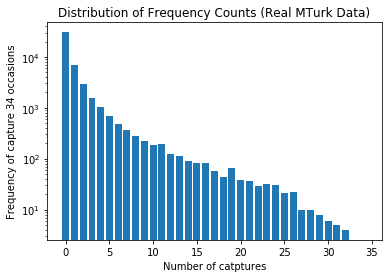

In [3]:
plt.bar(np.arange(S), dat[1:])
plt.yscale("log")
plt.ylabel("Frequency of capture 34 occasions")
plt.xlabel("Number of catptures")
plt.title("Distribution of Frequency Counts (Real MTurk Data)")

In [4]:
data[data['count'] > 32]

,count,max,min
index,,,
1140,33,34,0
14506,33,34,0
22509,33,34,0
28983,33,34,0


<BarContainer object of 36 artists>

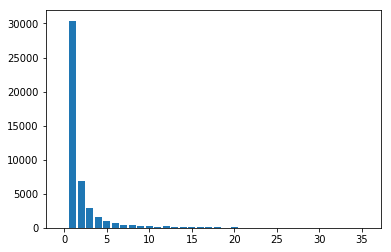

In [5]:
plt.bar(np.arange(S+1), dat)

In [10]:
def mll(initParams):
    # params
    f0    = initParams[0]
    alpha = initParams[1]
    beta  = initParams[2]
    p     = initParams[3]
    mix   = initParams[4]
    
    # N! / f0!
    N = gammaln(V + f0 +1) - gammaln(f0 + 1)
    L0 = f0 * np.log( (mix * Bin(S, 0, p)) +  ((1 - mix) * BB(S, 0, alpha, beta)) )
    Lk = 0
    
    # fk likelihood
    for k in range(1, len(dat)):
        Lk += dat[k] * np.log(  (mix * Bin(S, k, p)) +  ((1 - mix) * BB(S, k, alpha, beta)) )
    
    obj = N + L0 + Lk
    print(mix, p, alpha, beta, f0, -obj, N, L0, Lk, BB(S, 0, alpha, beta) )
    return -obj

In [11]:
# Alpha Beta version
def BB(S, k, alpha, beta):
    up = gamma(k + alpha) * gamma(S - k + beta) * gamma(alpha + beta)
    down = gamma(alpha) * gamma(beta) * gamma(S + alpha + beta)
    return up / down

def Bin(S, k, prob):
    Bi= k* np.log(prob) + (S-k) * np.log(1-prob)
    return np.exp(Bi)

In [12]:
def mll(initParams):
    # params
    f0 = initParams[0]
    alpha = initParams[1]
    beta = initParams[2]
    p = initParams[3]
    mix = initParams[4]
    
    # N! / f0!
    N = gammaln(V + f0 +1) - gammaln(f0 + 1)
    L0 = f0 * np.log(  (mix * Bin(S, 0, p)) +  ((1 - mix) * BB(S, 0, alpha, beta)))
    Lk = 0
    
    # fk likelihood
    for k in range(1, len(dat)):
        Lk += dat[k] * np.log(  (mix * Bin(S, k, p)) +  ((1 - mix) * BB(S, k, alpha, beta)))
    
    obj = N + L0 + Lk
    #if -obj < -10000:
    #    print(f0, alpha, beta, p, mix, -obj)
    return -obj

In [13]:
# Bounds
B= ((1000,100000), (0.3, 10), (2, None), (0.5, 1), (0.01,1))

#args
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)

#run
initParams = np.array([10000, 2, 5, .5, .8])
res = basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(res['x'][0] + V)

/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/ded/anacond

                        fun: -110546.05200380029
 lowest_optimization_result:       fun: -110546.05200380029
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([   -0.56461431,  -906.68909252,    32.10734576, 11634.0641398 ,
       -1828.47143151])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 16
   status: 0
  success: True
        x: array([9999.9823874 ,    3.1451889 ,   77.72960644,    0.5       ,
          0.02528948])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 94
                       nfev: 13878
                        nit: 100
                          x: array([9999.9823874 ,    3.1451889 ,   77.72960644,    0.5       ,
          0.02528948])
56113.98238740413


In [13]:
# Bounds
B= ((1,14), (0, 0.1), (0, 5), (0, .001), (0,1))

#args
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)

#run
initParams = np.array([1, .12, 5, .0005, .8])
res = basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs, niter = 50000)
print(res)
print(np.exp(res['x'][0]) + V)

/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/Users/ded/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


KeyboardInterrupt: 

In [61]:
mll([403608.7895533 ,      0.02039742,      3.7429387 ,      0.01037844,
            0.20782324])

-121061.20699431212

In [62]:
mll([83793.7773379 ,     0.19999895,     4.07278073,     0.01197954,
           0.70142692])

-120977.7095533876

In [64]:
mll([234776.72579006,      0.03929604,      3.78447354,      0.01050833,
            0.33356468])

-121053.78927293565

In [67]:
mll([57392.28189185,     0.38756928,     4.32406151,     0.01459061,
           0.80091354])

-120812.86576105905

In [114]:
mll([125104.16766101,      0.09702091,      3.89744013,      0.01093061,
            0.54677371])

-121029.53788561595

In [188]:
mll([11.03010376,  1.1       ,  6.66479873,  0.01335952,  0.89314851])

-120587.12622553745

In [202]:
mll([11.736900670364296,      0.09702091,      3.89744013,      0.01093061, 0.54677371])

125104.00000000009 0.09702091 3.89744013 0.01093061 0.54677371 -121029.53779149149


-121029.53779149149

In [38]:
mll([10000.25762527,     8.23930108,    86.84357609,     0.55497967,
           0.03809816])

-87262.46893670881